In [1]:
import os
import random
import numpy as np
import torch
import torchvision
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [2]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
#train and test data directory
train_data_dir = "./dataset/seg_train/seg_train/"
test_data_dir = "./dataset/seg_test/seg_test"

transform1 = transforms.Compose([transforms.Resize(size=[150, 150]),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0]) # 2. Perform 0, 1 normalization
                                 ])

#load the train and test data
train_dataset = ImageFolder(root=train_data_dir, transform=transform1)
test_dataset = ImageFolder(root=test_data_dir, transform=transform1)

In [4]:
mean_dataset = [0.43070727586746216, 0.45766621828079224, 0.45408812165260315]
std_dataset = [0.2356669157743454, 0.23458831012248993, 0.24301844835281372]

In [5]:
print("# tuples in the train dataset", len(train_dataset))
print("# tuples in the test dataset", len(test_dataset))

# tuples in the train dataset 14034
# tuples in the test dataset 3000


In [6]:
classes = test_dataset.classes
labels = test_dataset.targets
num_classes = len(classes)

In [7]:
class_to_labels_map = {
    0: "buildings",
    1: "forest",
    2: "glacier",
    3: "mountain",
    4: "sea",
    5: "street"
}

labels_to_class_map = {
    "buildings": 0,
    "forest": 1,
    "glacier": 2,
    "mountain": 3,
    "sea": 4,
    "street": 5
}

In [8]:
# Utils
def balanced_subset(dataset, num_samples_per_class=10):
  class_counts = {label: 0 for label in classes}
  indices = []

  for idx, (_, lbl) in enumerate(dataset):
    if class_counts[lbl] < num_samples_per_class:
      indices.append(idx)
      class_counts[lbl] += 1
      
  subset = Subset(dataset=test_dataset, indices=indices)
  return subset

In [9]:
def calculate_mean_std(dataset):
    channel_means = torch.zeros(3)
    channel_stds = torch.zeros(3)
    num_samples = len(dataset)

    for img, _ in dataset:
        # sum means of individual images => for n samples sum(mean(each_img))
        channel_means += torch.mean(img, dim=(1,2))
        channel_stds += torch.std(img, dim=(1, 2))
    
    channel_means /= num_samples
    channel_stds /= num_samples

    return channel_means.tolist(), channel_stds.tolist()

In [10]:
def freq_distribution(dataset):
  class_counts = [0] * num_classes

  for _, lbl in dataset:
    class_counts[lbl] += 1

  return class_counts

In [11]:
class CustomDataset(Dataset):
  def __init__(self, root_folder, num_samples_per_class, transform=None):
    self.num_samples_per_class = num_samples_per_class
    self.transform = transform

    self.samples = []
    self.labels = []

    for class_folder in os.listdir(root_folder):
      class_folder_path = os.path.join(root_folder, class_folder)
      files = os.listdir(class_folder_path)
      selected_files = random.sample(files, self.num_samples_per_class)

      for file in selected_files:
        file_path = os.path.join(class_folder_path, file)
        self.samples.append(file_path)
        self.labels.append(labels_to_class_map[class_folder])

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, index):
    sample_path = self.samples[index]
    label = self.labels[index]

    sample = Image.open(sample_path).convert("RGB")
    if self.transform:
      sample = self.transform(sample)

    return (sample, label)

In [12]:
debug_dataset = CustomDataset(root_folder=test_data_dir, num_samples_per_class=6, transform=transform1)

In [13]:
# Visualize

def display_img(img, label):
    print(f"Label : {classes[label]}")
    plt.imshow(img.permute(1,2,0))

In [14]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        # make_grid construrcts a large image instead individual figs like in matplotlib
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

In [15]:
img1, lbl = train_dataset[0]
print(img1.permute(1,2,0).shape, lbl)
print("Follwing classes are there : \n", train_dataset.classes)

torch.Size([150, 150, 3]) 0
Follwing classes are there : 
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Label : buildings


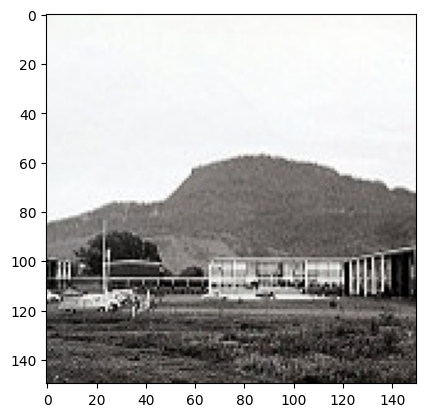

In [16]:
display_img(img1, lbl)

In [17]:
train_freq = freq_distribution(train_dataset)
test_freq = freq_distribution(test_dataset)
debug_freq = freq_distribution(debug_dataset)

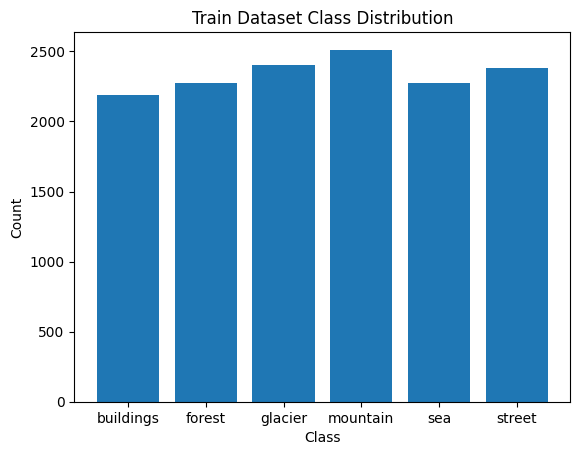

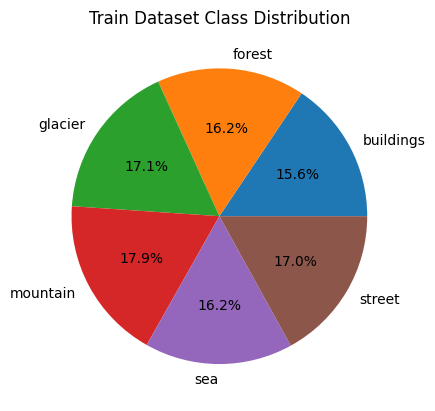

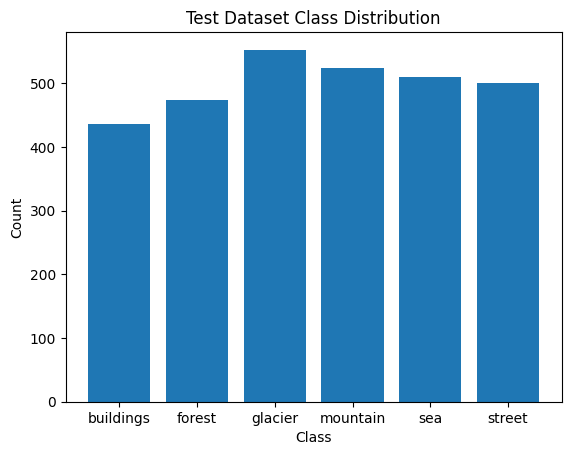

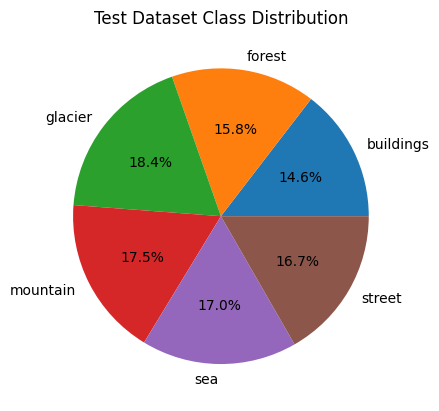

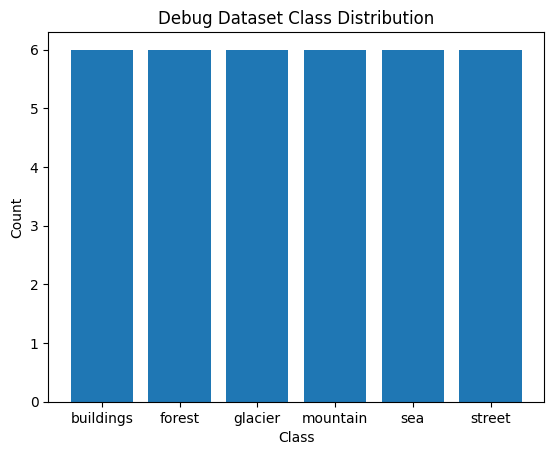

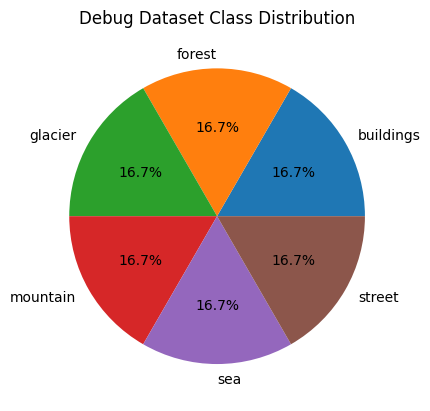

In [18]:
# Train
# Visualize the class distribution
plt.title("Train Dataset Class Distribution")
plt.bar(range(num_classes), train_freq)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(num_classes), classes)
plt.show()

# Visualize the class distribution as a pie chart
plt.pie(train_freq, labels=classes, autopct="%1.1f%%")
plt.title("Train Dataset Class Distribution")
plt.show()

# Test
# bar
plt.title("Test Dataset Class Distribution")
plt.bar(range(num_classes), test_freq)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(num_classes), classes)
plt.show()

# pie
plt.pie(test_freq, labels=classes, autopct="%1.1f%%")
plt.title("Test Dataset Class Distribution")
plt.show()

# Debug
# bar
plt.title("Debug Dataset Class Distribution")
plt.bar(range(num_classes), debug_freq)
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(num_classes), classes)
plt.show()

# pie
plt.pie(debug_freq, labels=classes, autopct="%1.1f%%")
plt.title("Debug Dataset Class Distribution")
plt.show()

In [19]:
concat_dataset = ConcatDataset([train_dataset, test_dataset])

In [20]:
# mean_dataset, std_dataset = calculate_mean_std(concat_dataset)

In [21]:
print("mean_dataset: ", mean_dataset)
print("std_dataset: ", std_dataset)

mean_dataset:  [0.43070727586746216, 0.45766621828079224, 0.45408812165260315]
std_dataset:  [0.2356669157743454, 0.23458831012248993, 0.24301844835281372]


In [22]:
batch_size = 8
#load the train and validation into batches.
train_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_dataset, batch_size*2, shuffle=True, num_workers = 4, pin_memory = True)
debug_dl = DataLoader(debug_dataset, batch_size=16, shuffle=True, pin_memory=True)

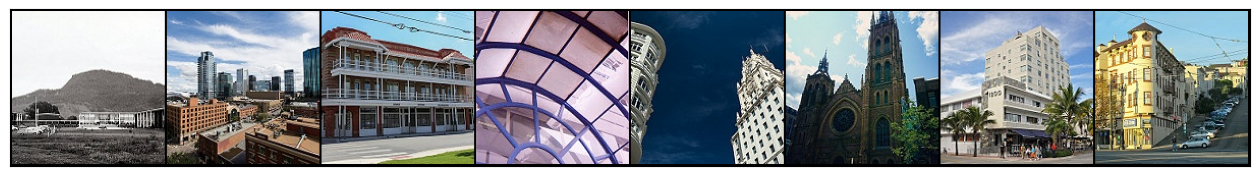

In [23]:
show_batch(train_dl)

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
def precision(outputs, labels):
    precision = torch.zeros(num_classes)
    _, preds = torch.max(outputs, dim=1)
    for c in range(num_classes):
        true_positives = torch.sum((preds == c) & (labels == c)).item()
        false_positives = torch.sum((preds == c) & (labels != c)).item()
        
        precision[c] = true_positives / (true_positives + false_positives + 1e-10)
    return precision

In [26]:
def recall(outputs, labels):
    recall = torch.zeros(num_classes)
    _, preds = torch.max(outputs, dim=1)
    for c in range(num_classes):
        true_positives = torch.sum((preds == c) & (labels == c)).item()
        false_negatives = torch.sum((preds != c) & (labels == c)).item()

        recall[c] = true_positives / (true_positives + false_negatives + 1e-10)     
    return recall

In [27]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        # reduction argument is None by default
        train_loss = F.cross_entropy(out, labels) # Calculate loss
        
        train_acc = accuracy(out, )
        return {"out": out, "train_loss": train_loss}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions

        val_loss = F.cross_entropy(out, labels)   # Calculate loss

        val_acc = accuracy(out, labels)           # Calculate accuracy
        val_prec = precision(out, labels)
        val_rec = recall(out, labels)
        return {'val_loss': val_loss.detach(),
                'val_acc': val_acc,
                'val_prec': val_prec,
                'val_rec': val_rec}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        batch_precs = [x["val_prec"] for x in outputs]
        epoch_prec = torch.stack(batch_precs).mean(dim=0)      # Combine accuracies

        batch_recs = [x["val_rec"] for x in outputs]
        epoch_rec = torch.stack(batch_recs).mean(dim=0)      # Combine accuracies

        return {"val_loss": epoch_loss.item(),
                "val_acc": epoch_acc.item(),
                "val_prec": epoch_prec,
                "val_rec": epoch_rec}
    
    def training_epoch_end(self, outputs):
        pass

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, val_prec: {}, val_rec: {}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc'], result['val_prec'], result['val_rec']))

In [28]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # [(W−K+2P)/S]+1 and here [] brackets means floor division
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    # tells the model we are about to validate and not train. It freezes the weights in the model.
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [35]:
# @torch.no_grad()
def evaluate_train_batch(train_losses, preds, lbls):
    # tells the model we are about to validate and not train. It freezes the weights in the model.
    loss = train_losses.mean().item()
    acc = accuracy(preds, lbls)
    prec = precision(preds, lbls)
    rec = recall(preds, lbls)
    return {"train_loss": loss, "train_acc": acc, "train_prec": prec, "train_rec": rec}

In [39]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(params=model.parameters(), lr=lr)
    for epoch in range(epochs):
        print("epoch [{}]".format(epoch))
        # tells the model we are in training. Eg: model might perform differently during training or validation
        model.train()
        # init logs
        train_losses = []
        batch_train_logs = []
        for batch_idx, batch in enumerate(train_loader):
            print("training batch {}".format(batch_idx))
            train_step = model.training_step(batch)

            train_losses.append(train_step["train_loss"])
            batch_train_logs.append(evaluate_train(train_step["train_loss"], train_step["out"], batch[1]))

            train_step["train_loss"].backward()
            optimizer.step()
            optimizer.zero_grad()
        
        train_result = 
    # return batch_train_logs
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [40]:
num_epochs = 2
opt_func = torch.optim.Adam
lr = 0.001
#fitting the model on training data and record the result after each epoch
model = NaturalSceneClassification()

# print(model)

In [41]:
history = fit(num_epochs, lr, model, debug_dl, debug_dl, opt_func)

epoch [0]
training batch 0
training batch 1
training batch 2


In [42]:
print(history)

[{'train_loss': 1.7858684062957764, 'train_acc': tensor(0.3750), 'train_prec': tensor([0.3750, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]), 'train_rec': tensor([1., 0., 0., 0., 0., 0.])}, {'train_loss': 2.205537796020508, 'train_acc': tensor(0.), 'train_prec': tensor([0., 0., 0., 0., 0., 0.]), 'train_rec': tensor([0., 0., 0., 0., 0., 0.])}, {'train_loss': 1.8665424585342407, 'train_acc': tensor(0.), 'train_prec': tensor([0., 0., 0., 0., 0., 0.]), 'train_rec': tensor([0., 0., 0., 0., 0., 0.])}]


In [ ]:
# batch_size = 128
# # Create a StratifiedKFold object
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Iterate over the folds
# for fold_num, (train_idx, val_idx) in enumerate(skf.split(debug_dataset, debug_dataset.labels)):

#   # Create the train and test DataLoaders
#   train_k_dataset = torch.utils.data.Subset(debug_dataset, train_idx)
#   val_k_dataset = torch.utils.data.Subset(debug_dataset, val_idx)

#   train_k_loader = DataLoader(train_k_dataset, batch_size=10, shuffle=True)
#   val_k_loader = DataLoader(val_k_dataset, batch_size=10, shuffle=False)

#   print(f"{train_idx} {val_idx}")
#   print(f"fold {fold_num}: {len(train_k_dataset)} {len(train_k_loader)} {len(val_k_dataset)} {len(val_k_loader)}")
#   # # Train and evaluate the model
#   # model = ...
#   # model.fit(train_loader)
#   # loss, accuracy = model.evaluate(test_loader)

#   # # Print the fold number, loss, and accuracy
#   # print(f"Fold {fold_num}: loss={loss}, accuracy={accuracy}")

In [ ]:
# num_classes = len(train_dataset.classes)
# labels_map = {
#     0: "buildings",
#     1: "forest",
#     2: "glacier",
#     3: "mauntain",
#     4: "sea",
#     5: "street"
# }

In [ ]:
# def display_img(img,label):
#     print(f"Label : {train_dataset.classes[label]}")
#     plt.imshow(img.permute(1,2,0))
    
# display_img(img1, lbl)

In [ ]:
# transform_mean_std = transforms.Compose([
#     transforms.Resize((150, 150)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean_dataset,std=std_dataset)
# ])

In [ ]:
# train_dataset_mean_std = ImageFolder(root=train_data_dir, transform=transform_mean_std)

In [ ]:
# img, lbl = train_dataset_mean_std[0]
# display_img(img=img, label=lbl)

In [ ]:
# val_size = 2000
# train_size = len(train_dataset) - val_size 

# generator = torch.Generator().manual_seed(42)
# train_data, val_data = random_split(train_dataset, [train_size,val_size], generator=generator)
# print(f"Length of Train Data : {len(train_data)}")
# print(f"Length of Validation Data : {len(val_data)}")

#output
#Length of Train Data : 12034
#Length of Validation Data : 2000

# batch_size = 128
# #load the train and validation into batches.
# train_dl = DataLoader(train_dataset, batch_size, shuffle = False, num_workers = 4, pin_memory = True)
# test_dl = DataLoader(test_dataset, batch_size*2, shuffle=False, num_workers = 4, pin_memory = True)